In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Navigate to the Directory Containing the CSV File
import os
os.chdir('/content/drive/My Drive/DS266 Project')

In [ ]:
# Install the most recent version of TensorFlow to use the improved masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 111.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 37.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are in

In [ ]:
# Install compatible TensorFlow version
!pip uninstall tensorflow -y
!pip install tensorflow==2.15

# Reinstall tf-keras to resolve any potential dependency conflicts
!pip uninstall tf-keras -y
!pip install tf-keras

!pip uninstall tensorflow-text -y
!pip install tensorflow-text==2.15

!pip install bayesian-optimization
!pip install optuna

Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Successfully uninstalled tensorflow-2.16.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 86.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensor

In [ ]:
import logging
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_text as text

from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bayes_opt import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping

## Prep the Data

In [ ]:
# Read the CSV file
tweets_df = pd.read_csv('train.csv')

# Extract sentences and labels
sentences = tweets_df['text']
labels = tweets_df['target']

# Setup the tokenizer and preprocess the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
MAX_TOKENS = 30
sequences = tokenizer.texts_to_sequences(sentences)
sequences = pad_sequences(sequences, maxlen=MAX_TOKENS, padding='post')
labels = labels.to_numpy()

# Split the data into training and validation sets
sequences_train, sequences_val, labels_train, labels_val = train_test_split(
    sequences, labels, test_size=0.3, random_state=42)

# Convert to TensorFlow Datasets and batching
BUFFER_SIZE = len(sequences_train)
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((sequences_train, labels_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((sequences_val, labels_val))
val_dataset = val_dataset.batch(BATCH_SIZE)

# Inspect the dataset
print("Training batch example:", next(iter(train_dataset)))
print("Validation batch example:", next(iter(val_dataset)))


Training batch example: (<tf.Tensor: shape=(64, 30), dtype=int32, numpy=
array([[ 5640,  5641,    12, ...,     0,     0,     0],
       [11505,    15,  1983, ...,     0,     0,     0],
       [  854,  1618,  1227, ...,     0,     0,     0],
       ...,
       [ 8476,    96,  8477, ...,     0,     0,     0],
       [ 5553,  4112,   612, ...,     0,     0,     0],
       [   10,    70,   146, ...,     0,     0,     0]], dtype=int32)>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0])>)
Validation batch example: (<tf.Tensor: shape=(64, 30), dtype=int32, numpy=
array([[   35,    14,    27, ...,     0,     0,     0],
       [    4,  1184,    29, ...,     0,     0,     0],
       [18421, 18422,   105, ...,     0,     0,     0],
       ...,
       [ 1471,   582,  1972, ...,     0,     0,

# Model 1: Transformer Classifier

In [ ]:
# Define model components
def positional_encoding(length, depth):
  depth = depth/2
  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)
  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
  return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
  """Custom Keras layer that integrates positional encodings with embeddings.

    This layer creates an embedding matrix for the vocabulary and adds positional
    encoding to inject some information about the relative or absolute position
    of the tokens in the sequence. The positional encodings have the same dimension
    as the embeddings, allowing the two to be summed.

    Args:
        vocab_size (int): Size of the vocabulary.
        d_model (int): Dimensionality of the embeddings.

    Attributes:
        d_model (int): Stored dimensionality of the model used in scaling calculations.
        embedding (tf.keras.layers.Embedding): Embedding layer for the tokens.
        pos_encoding (tf.Tensor): Precomputed positional encodings.
    """
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    """Generates a mask for padding tokens. This mask is then used to ignore these tokens."""
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    """Performs the embedding lookup and adds the positional encoding.

        Args:
            x (tf.Tensor): Tensor of token indices.

        Returns:
            tf.Tensor: Embedded and positionally encoded tensor.
        """
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # Scale embeddings
    x = x + self.pos_encoding[tf.newaxis, :length, :] # Add positional encoding
    return x

class BaseAttention(tf.keras.layers.Layer):
  """Base class for attention mechanisms.

    This class is designed to be extended by specific attention implementations.
    It initializes the components common to various attention mechanisms, such as
    multi-head attention, layer normalization, and addition for residual connections.

    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): Multi-head attention layer.
        layernorm (tf.keras.layers.LayerNormalization): Normalizes the layer outputs.
        add (tf.keras.layers.Add): Implements the residual connection by adding input to the layer output.
    """
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention):
  """Extends BaseAttention to apply self-attention to the inputs.

    This class uses a multi-head attention mechanism to allow the model to jointly
    attend to information from different representation subspaces at different positions.
    After the attention mechanism, the result is added to the original input (residual connection)
    and then passed through a layer normalization.

    Methods:
        call(x): Computes the self-attention and returns the transformed output.
    """
  def call(self, x):
    """Compute self-attention and apply normalization.

        Args:
            x (tf.Tensor): The input tensor.

        Returns:
            tf.Tensor: The output tensor after applying self-attention and layer normalization.
        """
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class FeedForward(tf.keras.layers.Layer):
  """Defines a feed-forward network layer which is used in the transformer.

    This class creates a two-layer neural network with a ReLU activation in between,
    followed by dropout for regularization, and a residual connection around the network.

    Args:
        d_model (int): Dimensionality of the input and output.
        dff (int): Dimensionality of the inner layer.
        dropout_rate (float): Dropout rate.

    Attributes:
        seq (tf.keras.Sequential): Sequential model performing the feed-forward operation.
        add (tf.keras.layers.Add): Layer to perform the addition in the residual connection.
        layer_norm (tf.keras.layers.LayerNormalization): Layer to normalize the data.
    """
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # First dense layer with ReLU
      tf.keras.layers.Dense(d_model),                 # Second dense layer
      tf.keras.layers.Dropout(dropout_rate)           # Dropout for regularization
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    """Applies the feed-forward network to x with a residual connection followed by layer normalization.

        Args:
            x (tf.Tensor): Input tensor.

        Returns:
            tf.Tensor: Normalized output tensor.
        """
    x = self.add([x, self.seq(x)])  # Apply residual connection
    x = self.layer_norm(x)          # Normalize the output
    return x

class EncoderLayer(tf.keras.layers.Layer):
  """Single encoder layer consisting of self-attention and feed-forward network.

    This class represents one layer of the transformer's encoder part, which includes
    a self-attention mechanism and a position-wise feed-forward network, both with
    residual connections and layer normalization.

    Args:
        d_model (int): Dimensionality of the input and output.
        num_heads (int): Number of attention heads.
        dff (int): Dimensionality of the feed-forward network's inner layer.
        dropout_rate (float): Dropout rate used in MultiHeadAttention and the feed-forward network.

    Attributes:
        self_attention (GlobalSelfAttention): The self-attention component of the encoder.
        ffn (FeedForward): The feed-forward network component of the encoder.
    """
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    """Process input through one encoder layer and return the output.

        Args:
            x (tf.Tensor): Input tensor to the encoder layer.

        Returns:
            tf.Tensor: Output tensor of the encoder layer.
        """
    x = self.self_attention(x)  # Apply self-attention
    x = self.ffn(x)             # Apply feed-forward network
    return x

class Encoder(tf.keras.layers.Layer):
  """The Encoder module of the Transformer model.

    This class aggregates multiple encoder layers, applies positional embeddings to the input,
    and processes the sequence through each encoder layer sequentially.

    Args:
        num_layers (int): Number of encoder layers.
        d_model (int): Dimensionality of the input and output of the encoder layers.
        num_heads (int): Number of attention heads in each encoder layer.
        dff (int): Dimensionality of the feed-forward network's inner layer in each encoder layer.
        vocab_size (int): Size of the vocabulary for embedding.
        dropout_rate (float): Dropout rate to be applied in each encoder layer and to the input.

    Attributes:
        d_model (int): Dimensionality of the model used in scaling calculations.
        num_layers (int): Total number of encoder layers.
        pos_embedding (PositionalEmbedding): Layer that adds positional embeddings to token embeddings.
        enc_layers (list): List of encoder layers.
        dropout (tf.keras.layers.Dropout): Dropout layer applied to the output of positional embeddings.
    """
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    """Processes input sequence through the encoder stack.

        Args:
            x (tf.Tensor): Input tensor to the encoder.

        Returns:
            tf.Tensor: Output tensor from the encoder.
        """
    x = self.pos_embedding(x)
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x

class TransformerClassifier(tf.keras.Model):
  """Transformer model for classification tasks.

    This class encapsulates the entire Transformer model tailored for a binary classification task.
    It includes an encoder and a final dense layer with a sigmoid activation function to produce a probability.

    Args:
        num_layers (int): Number of layers in the encoder.
        d_model (int): Dimensionality of the input and output of the encoder.
        num_heads (int): Number of attention heads in each encoder layer.
        dff (int): Dimensionality of the feed-forward network's inner layer.
        input_vocab_size (int): Size of the input vocabulary.
        dropout_rate (float): Dropout rate used throughout the encoder.

    Attributes:
        encoder (Encoder): The Transformer's encoder.
        final_layer (tf.keras.layers.Dense): Final dense layer used for binary classification.
    """
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    """Processes inputs through the encoder and the final dense layer.

        Args:
            inputs (tf.Tensor): Input tensor to the model.

        Returns:
            tf.Tensor: Output tensor representing the probability of the positive class.
        """
    context = inputs
    context = self.encoder(context)  # (batch_size, context_len, d_model)
    logits = self.final_layer(context[:, -1, :])  # Use the last hidden state
    return logits

# Instantiate the transformer model
model1 = TransformerClassifier(
    num_layers=2,
    d_model=100,
    num_heads=8,
    dff=512,
    input_vocab_size=max(tokenizer.word_index.values()) + 1,
    dropout_rate=0.2)

# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Ensure d_model is a float
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is a float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32 to ensure compatibility
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        # Ensure division by sqrt of d_model
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Return python float
            "warmup_steps": self.warmup_steps.numpy()  # Return python float
        }

# Instantiate the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=CustomSchedule(d_model=100),
                                     beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Compile model
model1.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
    run_eagerly=False)

# Define callbacks for checkpointing
checkpoint_dir = './model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'tx_w_embeddings_cl2.{epoch:02d}-{val_accuracy:.2f}'

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )]

## Training

In [ ]:
# Train the model
history_transformer = model1.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks_list)

# Specify the directory to save the model
model_dir = '/content/drive/My Drive/DS266 Project/model1_transformer_classifier'

# Save as TensorFlow SavedModel
model1.save(model_dir)  # Save the model using the SavedModel format

# To confirm the save, list the contents of the directory
!ls "{model_dir}"

Epoch 1/10
84/84 [==============================] - 19s 132ms/step - loss: 0.7625 - accuracy: 0.5314 - val_loss: 0.6794 - val_accuracy: 0.5775
Epoch 2/10
84/84 [==============================] - 6s 74ms/step - loss: 0.7086 - accuracy: 0.5457 - val_loss: 0.6768 - val_accuracy: 0.5534
Epoch 3/10
84/84 [==============================] - 4s 52ms/step - loss: 0.6779 - accuracy: 0.5759 - val_loss: 0.6480 - val_accuracy: 0.6064
Epoch 4/10
84/84 [==============================] - 3s 33ms/step - loss: 0.6006 - accuracy: 0.6710 - val_loss: 0.5435 - val_accuracy: 0.7364
Epoch 5/10
84/84 [==============================] - 3s 40ms/step - loss: 0.4852 - accuracy: 0.7699 - val_loss: 0.4877 - val_accuracy: 0.7824
Epoch 6/10
84/84 [==============================] - 2s 27ms/step - loss: 0.3942 - accuracy: 0.8290 - val_loss: 0.4686 - val_accuracy: 0.7973
Epoch 7/10
84/84 [==============================] - 2s 24ms/step - loss: 0.3153 - accuracy: 0.8696 - val_loss: 0.5058 - val_accuracy: 0.8004
Epoch 8/10


In [ ]:
# Print model summary
print(model1.summary())

Model: "transformer_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  3116924   
                                                                 
 dense_4 (Dense)             multiple                  101       
                                                                 
Total params: 3117025 (11.89 MB)
Trainable params: 3117025 (11.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Performance

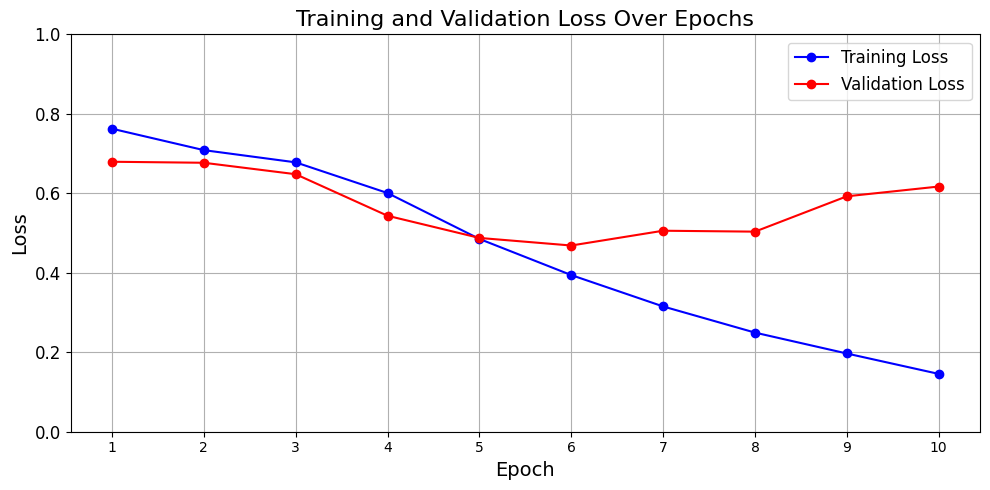

In [ ]:
def plot_loss(history_df, ymin=None, ymax=None):
    # Ensure the history_df is a DataFrame
    if not isinstance(history_df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame.")

    # Plotting training and validation loss
    plt.figure(figsize=(10, 5))  # Set the figure size for better readability
    plt.plot(history_df.index, history_df['loss'], label='Training Loss', marker='o', linestyle='-', color='blue')
    plt.plot(history_df.index, history_df['val_loss'], label='Validation Loss', marker='o', linestyle='-', color='red')

    plt.title('Training and Validation Loss Over Epochs', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.xticks(history_df.index)  # Set x-ticks to be explicit epochs
    plt.yticks(fontsize=12)       # Optional: improve readability of y-ticks
    plt.legend(fontsize=12)
    plt.grid(True)                # Enable grid to improve readability
    plt.tight_layout()            # Adjust subplots to give some padding

    # Set the limits for the y-axis if specified
    if ymin is not None or ymax is not None:
        plt.ylim([ymin, ymax])
    plt.show()

# Training history
history_model1_df = pd.DataFrame(history_transformer.history)

# Reset the index to start with 1
history_model1_df.index = range(1, len(history_model1_df) + 1)

# Calling the improved plot function
plot_loss(history_model1_df, ymin=0, ymax=1)


## Enhanced dataset

In [ ]:
# Read the CSV file
tweets_df = pd.read_csv('train_enhanced.csv')

# Extract sentences and labels
sentences = tweets_df['cleaned_text']
labels = tweets_df['target']

# Setup the tokenizer and preprocess the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
MAX_TOKENS = 30
sequences = tokenizer.texts_to_sequences(sentences)
sequences = pad_sequences(sequences, maxlen=MAX_TOKENS, padding='post')
labels = labels.to_numpy()

# Split the data into training and validation sets
sequences_train, sequences_val, labels_train, labels_val = train_test_split(
    sequences, labels, test_size=0.3, random_state=42)

# Convert to TensorFlow Datasets and batching
BUFFER_SIZE = len(sequences_train)
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((sequences_train, labels_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((sequences_val, labels_val))
val_dataset = val_dataset.batch(BATCH_SIZE)

# Inspect the dataset
print("Training batch example:", next(iter(train_dataset)))
print("Validation batch example:", next(iter(val_dataset)))

Training batch example: (<tf.Tensor: shape=(64, 30), dtype=int32, numpy=
array([[   8,    5,   10, ...,    6,    4,   16],
       [   8,    5,   10, ...,    6,    4,   16],
       [   8,    5,   10, ...,    6,    4,   16],
       ...,
       [1196,  126,  545, ...,    0,    0,    0],
       [   8,    5,   10, ...,    6,    4,   16],
       [  31,   70,    5, ...,    0,    0,    0]], dtype=int32)>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1])>)
Validation batch example: (<tf.Tensor: shape=(64, 30), dtype=int32, numpy=
array([[10795,   618,   858, ...,     0,     0,     0],
       [  374, 20450,  1053, ...,     0,     0,     0],
       [  129,   145,   108, ...,     6,     4,    55],
       ...,
       [    8,     5,    10, ...,     6,     4,    16],
       [   42,  3157,     8

In [ ]:
# Train the model
history_model1b = model1.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks_list)

# Specify the directory to save the model
model_dir = '/content/drive/My Drive/DS266 Project/model1_enhanced_dataset'

# Save as TensorFlow SavedModel
model1.save(model_dir)  # Save the model using the SavedModel format

# To confirm the save, list the contents of the directory
!ls "{model_dir}"

Epoch 1/10
269/269 [==============================] - 26s 97ms/step - loss: 0.3669 - accuracy: 0.7973 - val_loss: 0.2967 - val_accuracy: 0.8541
Epoch 2/10
269/269 [==============================] - 10s 38ms/step - loss: 0.2674 - accuracy: 0.8699 - val_loss: 0.3256 - val_accuracy: 0.8465
Epoch 3/10
269/269 [==============================] - 8s 30ms/step - loss: 0.2351 - accuracy: 0.8861 - val_loss: 0.2647 - val_accuracy: 0.8747
Epoch 4/10
269/269 [==============================] - 6s 20ms/step - loss: 0.2166 - accuracy: 0.8950 - val_loss: 0.2536 - val_accuracy: 0.8797
Epoch 5/10
269/269 [==============================] - 5s 19ms/step - loss: 0.2154 - accuracy: 0.8988 - val_loss: 0.2614 - val_accuracy: 0.8792
Epoch 6/10
269/269 [==============================] - 6s 21ms/step - loss: 0.2110 - accuracy: 0.8968 - val_loss: 0.2629 - val_accuracy: 0.8815
Epoch 7/10
269/269 [==============================] - 5s 18ms/step - loss: 0.2095 - accuracy: 0.9003 - val_loss: 0.2751 - val_accuracy: 0.87

In [ ]:
# Print model summary
print(model1.summary())

Model: "transformer_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  3116924   
                                                                 
 dense_4 (Dense)             multiple                  101       
                                                                 
Total params: 3117025 (11.89 MB)
Trainable params: 3117025 (11.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


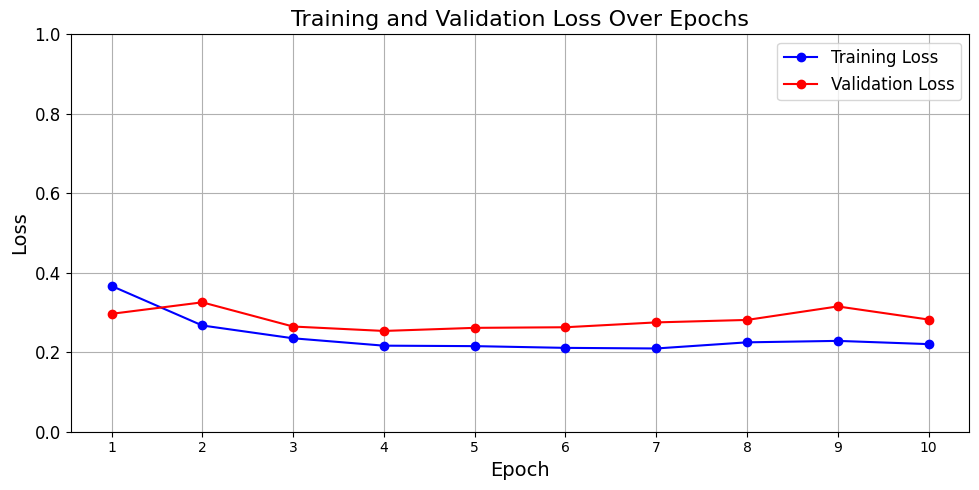

In [ ]:
# Training history
history_model1b_df = pd.DataFrame(history_model1b.history)

# Reset the index to start with 1
history_model1b_df.index = range(1, len(history_model1b_df) + 1)

file_path = '/content/drive/My Drive/DS266 Project/model1_enhanced_dataset.csv'

history_model1b_df.to_csv(file_path, index=False)

# Calling the improved plot function
plot_loss(history_model1b_df, ymin=0, ymax=1)


# Model 2: Learnable Positional Encodings

In [ ]:
# PositionalEmbedding with trainable positional encodings
class PositionalEmbedding(tf.keras.layers.Layer):
    """Custom Keras layer that integrates trainable positional encodings with token embeddings.

      This layer first creates an embedding matrix for the vocabulary and then adds trainable positional
      encodings to the token embeddings. The idea is to allow the model to learn the optimal positional
      encodings along with learning the token embeddings, which could provide more flexibility and
      potentially better performance for certain datasets or problems.

      Args:
          vocab_size (int): Size of the vocabulary. This determines the number of rows in the embedding matrix.
          d_model (int): The dimensionality of the embeddings. Each token is transformed into a vector of this size.
          maxlen (int): The maximum length of input sequences this embedding layer will be used with. This defines
                        the size of the positional encoding matrix, ensuring it can handle sequences up to this length.

      Attributes:
          d_model (int): Stored dimensionality of the embeddings, used for scaling the embeddings.
          embedding (tf.keras.layers.Embedding): The embedding layer that transforms token indices into embeddings.
          pos_encoding (tf.Variable): Trainable positional encodings added to token embeddings. Initialized with
                                      random values and learned during training.
      """
    def __init__(self, vocab_size, d_model, maxlen=2048):
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = self.add_weight("pos_encoding", shape=[maxlen, d_model], initializer="random_normal", trainable=True)

    def call(self, x):
      """Adds positional encoding to token embeddings.

        This method retrieves embeddings for input tokens and adds learned positional encodings
        to these embeddings. The embeddings are also scaled by the square root of the model's
        dimensionality, a common practice to help stabilize the learning.

        Args:
            x (tf.Tensor): Input tensor containing token indices of shape (batch_size, sequence_length).

        Returns:
            tf.Tensor: Output tensor of the same shape as `x` but with embeddings that now include
                        positional information. The shape is (batch_size, sequence_length, d_model).
        """
      length = tf.shape(x)[1] # Determine the sequence length of the current batch.
      x = self.embedding(x) * tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # Lookup token embeddings.
      x += self.pos_encoding[:length, :] # Add the appropriate positional encodings up to the current sequence length.
      return x


# BaseAttention layer extended for self-attention mechanism
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GlobalSelfAttention(BaseAttention):
    def call(self, x):
      attn_output = self.mha(
          query=x,
          value=x,
          key=x)
      x = self.add([x, attn_output])
      x = self.layernorm(x)
      return x

class FeedForward(tf.keras.layers.Layer):
    """Defines a feed-forward network layer which is used in the transformer.

      This class creates a two-layer neural network with a ReLU activation in between,
      followed by dropout for regularization, and a residual connection around the network.

      Args:
          d_model (int): Dimensionality of the input and output.
          dff (int): Dimensionality of the inner layer.
          dropout_rate (float): Dropout rate.

      Attributes:
          seq (tf.keras.Sequential): Sequential model performing the feed-forward operation.
          add (tf.keras.layers.Add): Layer to perform the addition in the residual connection.
          layer_norm (tf.keras.layers.LayerNormalization): Layer to normalize the data.
      """
    def __init__(self, d_model, dff, dropout_rate=0.1):
      super().__init__()
      self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # First dense layer with ReLU
        tf.keras.layers.Dense(d_model),                 # Second dense layer
        tf.keras.layers.Dropout(dropout_rate)           # Dropout for regularization
      ])
      self.add = tf.keras.layers.Add()
      self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
      """Applies the feed-forward network to x with a residual connection followed by layer normalization.

          Args:
              x (tf.Tensor): Input tensor.

          Returns:
              tf.Tensor: Normalized output tensor.
          """
      x = self.add([x, self.seq(x)])  # Apply residual connection
      x = self.layer_norm(x)          # Normalize the output
      return x

# EncoderLayer combining self-attention and FeedForward
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

# Encoder comprising multiple EncoderLayers
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for layer in self.enc_layers:
            x = layer(x)
        return x

# Transformer classifier model
class TransformerClassifier(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        context = self.encoder(inputs)
        logits = self.final_layer(context[:, -1, :])  # Take last hidden state
        return logits

# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Ensure d_model is a float
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is a float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32 to ensure compatibility
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        # Ensure division by sqrt of d_model
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Return python float
            "warmup_steps": self.warmup_steps.numpy()  # Return python float
        }

# Instantiate the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=CustomSchedule(d_model=100),
                                     beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Instantiate the transformer model
model2 = TransformerClassifier(
    num_layers=2,
    d_model=100,
    num_heads=8,
    dff=512,
    input_vocab_size=max(tokenizer.word_index.values()) + 1,
    dropout_rate=0.2)

# Compile model
model2.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
    run_eagerly=False)

# Define checkpointing
checkpoint_dir = './model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'tx_w_embeddings_cl2.{epoch:02d}-{val_accuracy:.2f}'

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )]


## Training

In [ ]:
# Train the model
history_model2 = model2.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks_list)

# Specify the directory to save the model
model_dir = '/content/drive/My Drive/DS266 Project/model2_learnable_encodings'

# Save as TensorFlow SavedModel
model1.save(model_dir)  # Save the model using the SavedModel format

# To confirm the save, list the contents of the directory
!ls "{model_dir}"

Epoch 1/10
269/269 [==============================] - 32s 96ms/step - loss: 0.5459 - accuracy: 0.7018 - val_loss: 0.2758 - val_accuracy: 0.8578
Epoch 2/10
269/269 [==============================] - 11s 39ms/step - loss: 0.2700 - accuracy: 0.8665 - val_loss: 0.2428 - val_accuracy: 0.8849
Epoch 3/10
269/269 [==============================] - 7s 26ms/step - loss: 0.2259 - accuracy: 0.8906 - val_loss: 0.2366 - val_accuracy: 0.8869
Epoch 4/10
269/269 [==============================] - 6s 24ms/step - loss: 0.1964 - accuracy: 0.9038 - val_loss: 0.2456 - val_accuracy: 0.8853
Epoch 5/10
269/269 [==============================] - 6s 21ms/step - loss: 0.1710 - accuracy: 0.9171 - val_loss: 0.3071 - val_accuracy: 0.8753
Epoch 6/10
269/269 [==============================] - 5s 20ms/step - loss: 0.1454 - accuracy: 0.9283 - val_loss: 0.3309 - val_accuracy: 0.8633
Epoch 7/10
269/269 [==============================] - 5s 19ms/step - loss: 0.1313 - accuracy: 0.9349 - val_loss: 0.3255 - val_accuracy: 0.87

In [ ]:
# Print model summary
print(model2.summary())

Model: "transformer_classifier_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  3328024   
                                                                 
 dense_19 (Dense)            multiple                  101       
                                                                 
Total params: 3328125 (12.70 MB)
Trainable params: 3328125 (12.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Performance

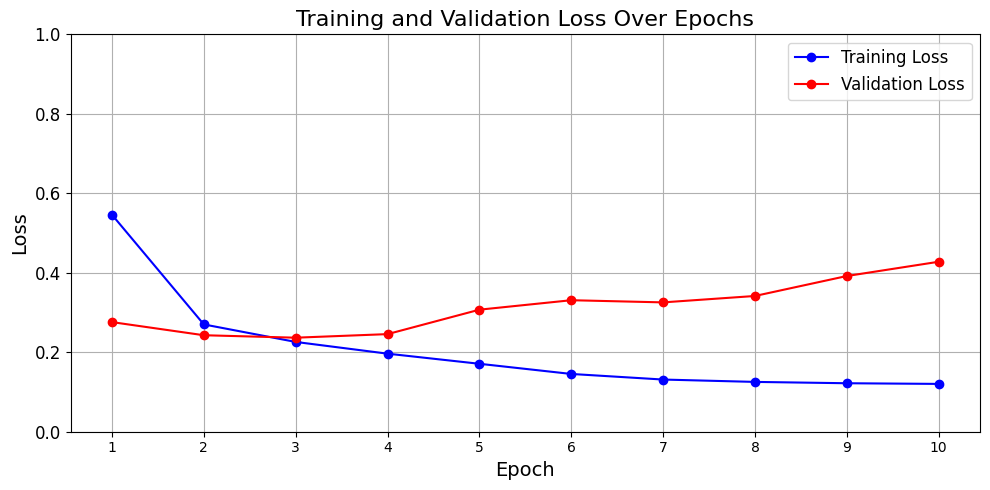

In [ ]:
# Training history
history_model2_df = pd.DataFrame(history_model2.history)

# Reset the index to start with 1
history_model2_df.index = range(1, len(history_model2_df) + 1)

file_path = '/content/drive/My Drive/DS266 Project/model2_learnable_encodings.csv'

history_model2_df.to_csv(file_path, index=False)

# Calling the improved plot function
plot_loss(history_model2_df, ymin=0, ymax=1)

# Model 3: Local Attention

In [ ]:
# Define model components
def positional_encoding(length, depth):
  depth = depth/2
  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)
  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
  return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
  """Custom Keras layer that integrates positional encodings with embeddings.

    This layer creates an embedding matrix for the vocabulary and adds positional
    encoding to inject some information about the relative or absolute position
    of the tokens in the sequence. The positional encodings have the same dimension
    as the embeddings, allowing the two to be summed.

    Args:
        vocab_size (int): Size of the vocabulary.
        d_model (int): Dimensionality of the embeddings.

    Attributes:
        d_model (int): Stored dimensionality of the model used in scaling calculations.
        embedding (tf.keras.layers.Embedding): Embedding layer for the tokens.
        pos_encoding (tf.Tensor): Precomputed positional encodings.
    """
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    """Generates a mask for padding tokens. This mask is then used to ignore these tokens."""
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    """Performs the embedding lookup and adds the positional encoding.

        Args:
            x (tf.Tensor): Tensor of token indices.

        Returns:
            tf.Tensor: Embedded and positionally encoded tensor.
        """
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # Scale embeddings
    x = x + self.pos_encoding[tf.newaxis, :length, :] # Add positional encoding
    return x

class LocalAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, window_size, **kwargs):
        super(LocalAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.window_size = window_size

        self.Wq = tf.keras.layers.Dense(d_model)
        self.Wk = tf.keras.layers.Dense(d_model)
        self.Wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        # Split the last dimension into (num_heads, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # Transpose the result such that the shape is (batch_size, num_heads, seq_length, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]
        q = self.split_heads(self.Wq(q), batch_size)
        k = self.split_heads(self.Wk(k), batch_size)
        v = self.split_heads(self.Wv(v), batch_size)

        # Ensure the windowing and transpose operations are compatible with the expected tensor ranks
        # Example simple attention score calculation without padding or windowing for simplicity
        scores = tf.matmul(q, k, transpose_b=True)
        scores /= tf.math.sqrt(tf.cast(self.depth, tf.float32))
        weights = tf.nn.softmax(scores, axis=-1)

        attention_output = tf.matmul(weights, v)
        attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
        attention_output = tf.reshape(attention_output, (batch_size, -1, self.num_heads * self.depth))

        return self.dense(attention_output)

class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

# FeedForward network
class FeedForward(tf.keras.layers.Layer):
  """Defines a feed-forward network layer which is used in the transformer.

    This class creates a two-layer neural network with a ReLU activation in between,
    followed by dropout for regularization, and a residual connection around the network.

    Args:
        d_model (int): Dimensionality of the input and output.
        dff (int): Dimensionality of the inner layer.
        dropout_rate (float): Dropout rate.

    Attributes:
        seq (tf.keras.Sequential): Sequential model performing the feed-forward operation.
        add (tf.keras.layers.Add): Layer to perform the addition in the residual connection.
        layer_norm (tf.keras.layers.LayerNormalization): Layer to normalize the data.
    """
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # First dense layer with ReLU
      tf.keras.layers.Dense(d_model),                 # Second dense layer
      tf.keras.layers.Dropout(dropout_rate)           # Dropout for regularization
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    """Applies the feed-forward network to x with a residual connection followed by layer normalization.

        Args:
            x (tf.Tensor): Input tensor.

        Returns:
            tf.Tensor: Normalized output tensor.
        """
    x = self.add([x, self.seq(x)])  # Apply residual connection
    x = self.layer_norm(x)          # Normalize the output
    return x

# EncoderLayer combining self-attention and FeedForward
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1, use_local_attention=False):
        super().__init__()
        self.use_local_attention = use_local_attention
        if self.use_local_attention:
            self.local_attention = LocalAttention(d_model=d_model, num_heads=num_heads, window_size=5)  # Adjust window_size as needed
        else:
            self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff, dropout_rate=dropout_rate)

    def call(self, x):
        if self.use_local_attention:
            x = self.local_attention(x, x, x)  # Assuming Q, K, V are all x
        else:
            x = self.self_attention(x)
        x = self.ffn(x)
        return x

# Encoder comprising multiple EncoderLayers
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1, use_local_attention=True):
        super().__init__()
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, use_local_attention=use_local_attention) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for layer in self.enc_layers:
            x = layer(x)
        return x

# Transformer classifier model
class TransformerClassifier(tf.keras.Model):
  """Transformer model for classification tasks.

    This class encapsulates the entire Transformer model tailored for a binary classification task.
    It includes an encoder and a final dense layer with a sigmoid activation function to produce a probability.

    Args:
        num_layers (int): Number of layers in the encoder.
        d_model (int): Dimensionality of the input and output of the encoder.
        num_heads (int): Number of attention heads in each encoder layer.
        dff (int): Dimensionality of the feed-forward network's inner layer.
        input_vocab_size (int): Size of the input vocabulary.
        dropout_rate (float): Dropout rate used throughout the encoder.

    Attributes:
        encoder (Encoder): The Transformer's encoder.
        final_layer (tf.keras.layers.Dense): Final dense layer used for binary classification.
    """
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, dropout_rate=0.1, use_local_attention=False):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate,
                           use_local_attention=use_local_attention)

    self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    """Processes inputs through the encoder and the final dense layer.

        Args:
            inputs (tf.Tensor): Input tensor to the model.

        Returns:
            tf.Tensor: Output tensor representing the probability of the positive class.
        """
    context = inputs
    context = self.encoder(context)  # (batch_size, context_len, d_model)
    logits = self.final_layer(context[:, -1, :])  # Use the last hidden state
    return logits

# Create the model instance
model3 = TransformerClassifier(
    num_layers=2,
    d_model=128,
    num_heads=8,
    dff=512,
    input_vocab_size=max(tokenizer.word_index.values()) + 1,
    dropout_rate=0.1,
    use_local_attention=True)

# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Ensure d_model is a float
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is a float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32 to ensure compatibility
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        # Ensure division by sqrt of d_model
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Return python float
            "warmup_steps": self.warmup_steps.numpy()  # Return python float
        }

# Instantiate the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=CustomSchedule(d_model=128),
                                     beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Compile model
model3.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
    run_eagerly=False)

# Define checkpointing
checkpoint_dir = './model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'tx_w_embeddings_cl2.{epoch:02d}-{val_accuracy:.2f}'

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )]


## Training

In [ ]:
# Start training
history_model3 = model3.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Specify the directory to save the model
model_dir = '/content/drive/My Drive/DS266 Project/model3_local_attention'

# Save as TensorFlow SavedModel
model1.save(model_dir)  # Save the model using the SavedModel format

# To confirm the save, list the contents of the directory
!ls "{model_dir}"

Epoch 1/10
269/269 [==============================] - 21s 59ms/step - loss: 0.4862 - accuracy: 0.7235 - val_loss: 0.2785 - val_accuracy: 0.8625
Epoch 2/10
269/269 [==============================] - 6s 23ms/step - loss: 0.2743 - accuracy: 0.8631 - val_loss: 0.2401 - val_accuracy: 0.8823
Epoch 3/10
269/269 [==============================] - 6s 21ms/step - loss: 0.2371 - accuracy: 0.8821 - val_loss: 0.2350 - val_accuracy: 0.8827
Epoch 4/10
269/269 [==============================] - 5s 19ms/step - loss: 0.2033 - accuracy: 0.9003 - val_loss: 0.2676 - val_accuracy: 0.8781
Epoch 5/10
269/269 [==============================] - 4s 15ms/step - loss: 0.1723 - accuracy: 0.9172 - val_loss: 0.2868 - val_accuracy: 0.8818
Epoch 6/10
269/269 [==============================] - 3s 13ms/step - loss: 0.1471 - accuracy: 0.9269 - val_loss: 0.2884 - val_accuracy: 0.8778
Epoch 7/10
269/269 [==============================] - 4s 14ms/step - loss: 0.1325 - accuracy: 0.9310 - val_loss: 0.3937 - val_accuracy: 0.873

In [ ]:
# Print model summary
print(model3.summary())

Model: "transformer_classifier_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_7 (Encoder)         multiple                  3303424   
                                                                 
 dense_63 (Dense)            multiple                  129       
                                                                 
Total params: 3303553 (12.60 MB)
Trainable params: 3303553 (12.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Performance

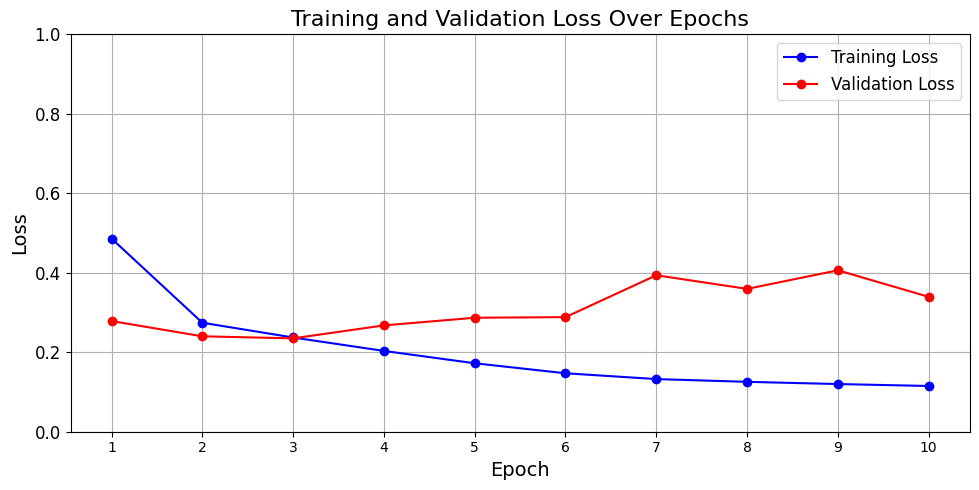

In [ ]:
# Training history
history_model3_df = pd.DataFrame(history_model3.history)

# Reset the index to start with 1
history_model3_df.index = range(1, len(history_model3_df) + 1)

# Save DataFrame as CSV
file_path = '/content/drive/My Drive/DS266 Project/model3_local_attention.csv'

history_model3_df.to_csv(file_path, index=False)

# Calling the improved plot function
plot_loss(history_model3_df, ymin=0, ymax=1)


# Model 4: Adaptive Attention Span

In [ ]:
def positional_encoding(length, d_model):
    # Generate positional encodings with proper depth handling
    angle_rads = np.arange(length)[:, np.newaxis] * (1 / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / d_model))
    # Apply sine to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])
    # Apply cosine to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(2048, d_model)  # Precomputed for max length

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # Scale embeddings
        # Add positional encoding up to the actual sequence length
        x += self.pos_encoding[:length, :]
        return x

class MinMaxValueConstraint(tf.keras.constraints.Constraint):
    """Ensures weights are within [min_value, max_value]."""
    def __init__(self, min_value, max_value):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, w):
        return tf.clip_by_value(w, self.min_value, self.max_value)

class AdaptiveAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, max_tokens):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        if d_model % num_heads != 0:
            raise ValueError("d_model must be divisible by num_heads")
        self.max_tokens = max_tokens

        self.WQ = tf.keras.layers.Dense(d_model)
        self.WK = tf.keras.layers.Dense(d_model)
        self.WV = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        # Calculate the new shape to split the heads
        new_shape = (batch_size, -1, self.num_heads, self.depth)
        x = tf.reshape(x, new_shape)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.WQ(q)
        k = self.WK(k)
        v = self.WV(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        return output

# BaseAttention layer extended for self-attention mechanism
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GlobalSelfAttention(BaseAttention):
  """Extends BaseAttention to apply self-attention to the inputs.

    This class uses a multi-head attention mechanism to allow the model to jointly
    attend to information from different representation subspaces at different positions.
    After the attention mechanism, the result is added to the original input (residual connection)
    and then passed through a layer normalization.

    Methods:
        call(x): Computes the self-attention and returns the transformed output.
    """
  def call(self, x):
    """Compute self-attention and apply normalization.

        Args:
            x (tf.Tensor): The input tensor.

        Returns:
            tf.Tensor: The output tensor after applying self-attention and layer normalization.
        """
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

# FeedForward network with residual connection
class FeedForward(tf.keras.layers.Layer):
  """Defines a feed-forward network layer which is used in the transformer.

    This class creates a two-layer neural network with a ReLU activation in between,
    followed by dropout for regularization, and a residual connection around the network.

    Args:
        d_model (int): Dimensionality of the input and output.
        dff (int): Dimensionality of the inner layer.
        dropout_rate (float): Dropout rate.

    Attributes:
        seq (tf.keras.Sequential): Sequential model performing the feed-forward operation.
        add (tf.keras.layers.Add): Layer to perform the addition in the residual connection.
        layer_norm (tf.keras.layers.LayerNormalization): Layer to normalize the data.
    """
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # First dense layer with ReLU
      tf.keras.layers.Dense(d_model),                 # Second dense layer
      tf.keras.layers.Dropout(dropout_rate)           # Dropout for regularization
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    """Applies the feed-forward network to x with a residual connection followed by layer normalization.

        Args:
            x (tf.Tensor): Input tensor.

        Returns:
            tf.Tensor: Normalized output tensor.
        """
    x = self.add([x, self.seq(x)])  # Apply residual connection
    x = self.layer_norm(x)          # Normalize the output
    return x

# EncoderLayer combining self-attention and FeedForward
class EncoderLayer(tf.keras.layers.Layer):
    """Single encoder layer consisting of attention and feed-forward network.

    Args:
        d_model (int): Dimensionality of the input and output.
        num_heads (int): Number of attention heads.
        dff (int): Dimensionality of the feed-forward network's inner layer.
        dropout_rate (float): Dropout rate used in the attention layer.
        max_tokens (int): Maximum length of input sequences for adaptive attention.
        use_adaptive_attention (bool): Flag to use adaptive attention instead of global self-attention.
    """
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1, max_tokens=2048, use_adaptive_attention=False):
        super().__init__()
        if use_adaptive_attention:
            self.attention = AdaptiveAttentionLayer(d_model=d_model, num_heads=num_heads, max_tokens=max_tokens)
        else:
            self.attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff, dropout_rate=dropout_rate)

    def call(self, x):
        x = self.attention(x, x, x)  # Assuming Q, K, V are all x for simplicity
        x = self.ffn(x)
        return x

# Encoder comprising multiple EncoderLayers
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1, use_adaptive_attention=False):
        super().__init__()
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = [
            EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate,
                         use_adaptive_attention=use_adaptive_attention) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for layer in self.enc_layers:
            x = layer(x)
        return x

# Transformer classifier model
class TransformerClassifier(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate=0.1, use_adaptive_attention=False):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size, dropout_rate=dropout_rate,
                               use_adaptive_attention=use_adaptive_attention)
        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        context = self.encoder(inputs)
        logits = self.final_layer(context[:, -1, :])
        return logits

# Create the model instance
model4 = TransformerClassifier(
    num_layers=2,
    d_model=100,
    num_heads=5,
    dff=512,
    input_vocab_size=max(tokenizer.word_index.values()) + 1,
    dropout_rate=0.1,
    use_adaptive_attention=True)

# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Ensure d_model is a float
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is a float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32 to ensure compatibility
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        # Ensure division by sqrt of d_model
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Return python float
            "warmup_steps": self.warmup_steps.numpy()  # Return python float
        }

# Instantiate the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=CustomSchedule(d_model=100),
                                     beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Compile the model
model4.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
    run_eagerly=False)

# Define callbacks for checkpointing
checkpoint_dir = './model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'tx_w_embeddings_cl2.{epoch:02d}-{val_accuracy:.2f}'

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )]


## Training

In [ ]:
# Start training
history_model4 = model4.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks_list)

# Specify the directory to save the model
model_dir = '/content/drive/My Drive/DS266 Project/model4_adaptive_attention_span'

# Save as TensorFlow SavedModel
model1.save(model_dir)  # Save the model using the SavedModel format

# To confirm the save, list the contents of the directory
!ls "{model_dir}"

Epoch 1/10
269/269 [==============================] - 21s 58ms/step - loss: 0.4400 - accuracy: 0.7545 - val_loss: 0.3557 - val_accuracy: 0.8197
Epoch 2/10
269/269 [==============================] - 8s 32ms/step - loss: 0.2758 - accuracy: 0.8589 - val_loss: 0.2604 - val_accuracy: 0.8748
Epoch 3/10
269/269 [==============================] - 6s 22ms/step - loss: 0.2337 - accuracy: 0.8861 - val_loss: 0.2314 - val_accuracy: 0.8872
Epoch 4/10
269/269 [==============================] - 4s 15ms/step - loss: 0.2008 - accuracy: 0.9022 - val_loss: 0.2447 - val_accuracy: 0.8895
Epoch 5/10
269/269 [==============================] - 4s 15ms/step - loss: 0.1708 - accuracy: 0.9177 - val_loss: 0.2838 - val_accuracy: 0.8830
Epoch 6/10
269/269 [==============================] - 4s 15ms/step - loss: 0.1459 - accuracy: 0.9279 - val_loss: 0.3117 - val_accuracy: 0.8781
Epoch 7/10
269/269 [==============================] - 3s 12ms/step - loss: 0.1301 - accuracy: 0.9341 - val_loss: 0.3485 - val_accuracy: 0.880

In [ ]:
# Print model summary
print(model4.summary())

Model: "transformer_classifier_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_16 (Encoder)        multiple                  2538424   
                                                                 
 dense_151 (Dense)           multiple                  101       
                                                                 
Total params: 2538525 (9.68 MB)
Trainable params: 2538525 (9.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Performance

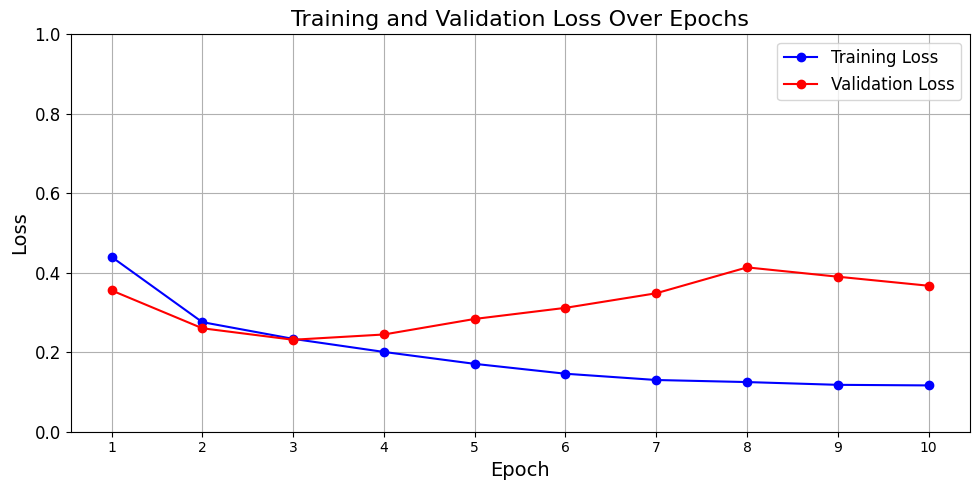

In [ ]:
# Training history
history_model4_df = pd.DataFrame(history_model4.history)

# Reset the index to start with 1
history_model4_df.index = range(1, len(history_model4_df) + 1)

# Save DataFrame as CSV
file_path = '/content/drive/My Drive/DS266 Project/model4_adaptive_attention.csv'

history_model4_df.to_csv(file_path, index=False)

# Calling the improved plot function
plot_loss(history_model4_df, ymin=0, ymax=1)

# Model 5: Implementing Custom Regularization

In [ ]:
# PositionalEmbedding layer
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, maxlen=30):
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model
        regularizer = tf.keras.regularizers.l1_l2(l1=10**-3.093, l2=10**-3.56)
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, embeddings_regularizer=regularizer)
        self.pos_encoding = self.add_weight("pos_encoding", shape=[maxlen, d_model], initializer="random_normal", trainable=True)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x) * tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:length, :]
        return x

class AdaptiveAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, max_tokens):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // self.num_heads
        self.max_tokens = max_tokens

        # Define L1 and L2 regularization
        regularizer = tf.keras.regularizers.l1_l2(l1=10**-3.093, l2=10**-3.56)

        # Initialize layers for projecting inputs to queries, keys, and values with regularization
        self.WQ = tf.keras.layers.Dense(d_model, kernel_regularizer=regularizer)
        self.WK = tf.keras.layers.Dense(d_model, kernel_regularizer=regularizer)
        self.WV = tf.keras.layers.Dense(d_model, kernel_regularizer=regularizer)

    def split_heads(self, x, batch_size):
        # Split the last dimension into (num_heads, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v):
        batch_size = tf.shape(q)[0]
        q = self.WQ(q)
        k = self.WK(k)
        v = self.WV(v)

        # Split the heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Scaled dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        return output

# BaseAttention layer
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim):
        super().__init__()
        regularizer = tf.keras.regularizers.l1_l2(l1=10**-3.093, l2=10**-3.56)
        # Explicitly pass num_heads and key_dim to MultiHeadAttention
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
        self.dense = tf.keras.layers.Dense(key_dim, kernel_regularizer=regularizer)

    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        attn_output = self.dense(attn_output)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GlobalSelfAttention(BaseAttention):
    def __init__(self, num_heads, key_dim):
        super().__init__(num_heads=num_heads, key_dim=key_dim)

    def call(self, x):
        return super().call(x)

# FeedForward network
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        regularizer = tf.keras.regularizers.l1_l2(l1=10**-3.093, l2=10**-3.56)
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu', kernel_regularizer=regularizer),
            tf.keras.layers.Dense(d_model, kernel_regularizer=regularizer),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()
    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

# EncoderLayer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate):
        super().__init__()
        self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = FeedForward(d_model, dff, dropout_rate=dropout_rate)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

# Encoder
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate, regularizer=None):
        super().__init__()
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model, maxlen=30)
        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for layer in self.enc_layers:
            x = layer(x)
        return x

# Define the Transformer model using AdaptiveAttentionLayer
class TransformerModel(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, max_tokens, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)
        self.adaptive_attention = AdaptiveAttentionLayer(d_model=d_model, num_heads=num_heads, max_tokens=max_tokens)
        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.adaptive_attention(x, x, x)  # Self-attention mechanism
        x = self.final_layer(x[:, -1, :])  # Take last hidden state
        return x

# Create and compile the model instance
model5 = TransformerModel(
    num_layers=2,
    d_model=100,
    num_heads=5,
    dff=512,
    input_vocab_size=max(tokenizer.word_index.values()) + 1,
    max_tokens=30,
    dropout_rate=0.1
)

# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Ensure d_model is a float
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is a float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32 to ensure compatibility
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        # Ensure division by sqrt of d_model
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Return python float
            "warmup_steps": self.warmup_steps.numpy()  # Return python float
        }

optimizer = tf.keras.optimizers.Adam(learning_rate=CustomSchedule(d_model=100),
                                     beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Compile the model
model5.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
    run_eagerly=False)

# Define callbacks for checkpointing
checkpoint_dir = './model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'tx_w_embeddings_cl2.{epoch:02d}-{val_accuracy:.2f}'

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )]


## Training

In [ ]:
# Train the model
history_model5 = model5.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks_list)

# Specify the directory to save the model
model_dir = '/content/drive/My Drive/DS266 Project/model5_implementing_custom_regularization'

# Save as TensorFlow SavedModel
model1.save(model_dir)  # Save the model using the SavedModel format

# To confirm the save, list the contents of the directory
!ls "{model_dir}"

Epoch 1/10
269/269 [==============================] - 14s 21ms/step - loss: 50.5510 - accuracy: 0.7666 - val_loss: 35.2123 - val_accuracy: 0.8578
Epoch 2/10
269/269 [==============================] - 5s 19ms/step - loss: 17.8833 - accuracy: 0.8664 - val_loss: 6.7682 - val_accuracy: 0.8786
Epoch 3/10
269/269 [==============================] - 5s 19ms/step - loss: 3.7752 - accuracy: 0.8773 - val_loss: 1.6120 - val_accuracy: 0.8820
Epoch 4/10
269/269 [==============================] - 5s 19ms/step - loss: 1.0214 - accuracy: 0.8795 - val_loss: 0.7058 - val_accuracy: 0.8789
Epoch 5/10
269/269 [==============================] - 5s 19ms/step - loss: 0.6186 - accuracy: 0.8812 - val_loss: 0.5710 - val_accuracy: 0.8785
Epoch 6/10
269/269 [==============================] - 5s 19ms/step - loss: 0.5492 - accuracy: 0.8867 - val_loss: 0.5407 - val_accuracy: 0.8782
Epoch 7/10
269/269 [==============================] - 5s 19ms/step - loss: 0.5363 - accuracy: 0.8839 - val_loss: 0.5379 - val_accuracy: 0.

In [ ]:
# Print model summary
print(model5.summary())

Model: "transformer_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_19 (Encoder)        multiple                  2904624   
                                                                 
 adaptive_attention_layer_1  multiple                  30300     
 9 (AdaptiveAttentionLayer)                                      
                                                                 
 dense_181 (Dense)           multiple                  101       
                                                                 
Total params: 2935025 (11.20 MB)
Trainable params: 2935025 (11.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Performance

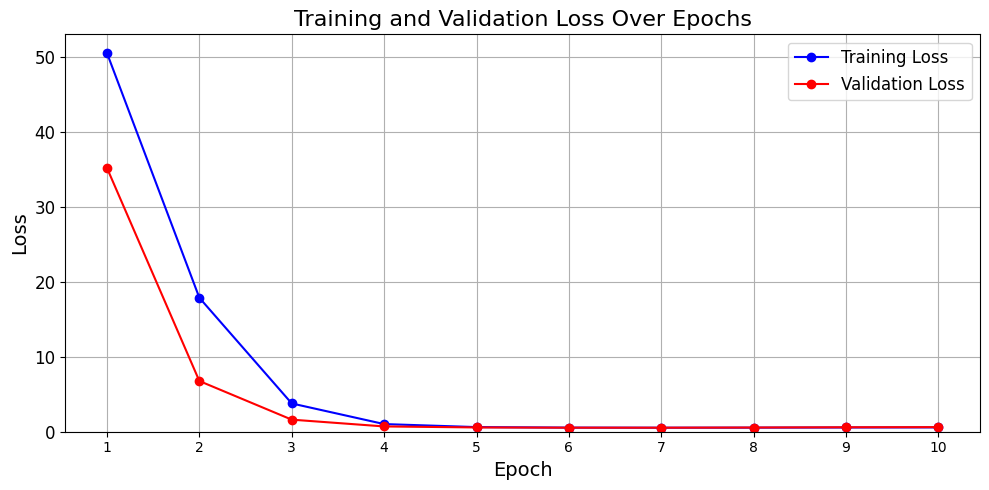

In [ ]:
# Training history
history_model5_df = pd.DataFrame(history_model5.history)

# Reset the index to start with 1
history_model5_df.index = range(1, len(history_model5_df) + 1)

# Save DataFrame as CSV
file_path = '/content/drive/My Drive/DS266 Project/model5_custom_regularization.csv'

history_model5_df.to_csv(file_path, index=False)

# Calling the improved plot function
plot_loss(history_model5_df, ymin=0, ymax=None)

#Hyperparameter Tuning

In [ ]:
# Model 2: Local Attention

class PositionalEmbedding(tf.keras.layers.Layer):
    """Custom Keras layer that integrates trainable positional encodings with token embeddings.

      This layer first creates an embedding matrix for the vocabulary and then adds trainable positional
      encodings to the token embeddings. The idea is to allow the model to learn the optimal positional
      encodings along with learning the token embeddings, which could provide more flexibility and
      potentially better performance for certain datasets or problems.

      Args:
          vocab_size (int): Size of the vocabulary. This determines the number of rows in the embedding matrix.
          d_model (int): The dimensionality of the embeddings. Each token is transformed into a vector of this size.
          maxlen (int): The maximum length of input sequences this embedding layer will be used with. This defines
                        the size of the positional encoding matrix, ensuring it can handle sequences up to this length.

      Attributes:
          d_model (int): Stored dimensionality of the embeddings, used for scaling the embeddings.
          embedding (tf.keras.layers.Embedding): The embedding layer that transforms token indices into embeddings.
          pos_encoding (tf.Variable): Trainable positional encodings added to token embeddings. Initialized with
                                      random values and learned during training.
      """
    def __init__(self, vocab_size, d_model, maxlen=2048):
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = self.add_weight("pos_encoding", shape=[maxlen, d_model], initializer="random_normal", trainable=True)

    def call(self, x):
      """Adds positional encoding to token embeddings.

        This method retrieves embeddings for input tokens and adds learned positional encodings
        to these embeddings. The embeddings are also scaled by the square root of the model's
        dimensionality, a common practice to help stabilize the learning.

        Args:
            x (tf.Tensor): Input tensor containing token indices of shape (batch_size, sequence_length).

        Returns:
            tf.Tensor: Output tensor of the same shape as `x` but with embeddings that now include
                        positional information. The shape is (batch_size, sequence_length, d_model).
        """
      length = tf.shape(x)[1] # Determine the sequence length of the current batch.
      x = self.embedding(x) * tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # Lookup token embeddings.
      x += self.pos_encoding[:length, :] # Add the appropriate positional encodings up to the current sequence length.
      return x


# BaseAttention layer extended for self-attention mechanism
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GlobalSelfAttention(BaseAttention):
    def call(self, x):
      attn_output = self.mha(
          query=x,
          value=x,
          key=x)
      x = self.add([x, attn_output])
      x = self.layernorm(x)
      return x

class FeedForward(tf.keras.layers.Layer):
    """Defines a feed-forward network layer which is used in the transformer.

      This class creates a two-layer neural network with a ReLU activation in between,
      followed by dropout for regularization, and a residual connection around the network.

      Args:
          d_model (int): Dimensionality of the input and output.
          dff (int): Dimensionality of the inner layer.
          dropout_rate (float): Dropout rate.

      Attributes:
          seq (tf.keras.Sequential): Sequential model performing the feed-forward operation.
          add (tf.keras.layers.Add): Layer to perform the addition in the residual connection.
          layer_norm (tf.keras.layers.LayerNormalization): Layer to normalize the data.
      """
    def __init__(self, d_model, dff, dropout_rate=0.1):
      super().__init__()
      self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # First dense layer with ReLU
        tf.keras.layers.Dense(d_model),                 # Second dense layer
        tf.keras.layers.Dropout(dropout_rate)           # Dropout for regularization
      ])
      self.add = tf.keras.layers.Add()
      self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
      """Applies the feed-forward network to x with a residual connection followed by layer normalization.

          Args:
              x (tf.Tensor): Input tensor.

          Returns:
              tf.Tensor: Normalized output tensor.
          """
      x = self.add([x, self.seq(x)])  # Apply residual connection
      x = self.layer_norm(x)          # Normalize the output
      return x

# EncoderLayer combining self-attention and FeedForward
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

# Encoder comprising multiple EncoderLayers
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for layer in self.enc_layers:
            x = layer(x)
        return x

# Transformer classifier model
class TransformerClassifier(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        context = self.encoder(inputs)
        logits = self.final_layer(context[:, -1, :])  # Take last hidden state
        return logits

# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Ensure d_model is a float
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is a float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32 to ensure compatibility
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        # Ensure division by sqrt of d_model
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Return python float
            "warmup_steps": self.warmup_steps.numpy()  # Return python float
        }

# Instantiate the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=CustomSchedule(d_model=100),
                                     beta_1=0.9, beta_2=0.98, epsilon=1e-9)


In [ ]:
import optuna

def create_model(trial):
    # Hyperparameters to tune
    num_layers = trial.suggest_int('num_layers', 1, 4)
    d_model = trial.suggest_categorical('d_model', [100, 128, 256])
    num_heads = trial.suggest_categorical('num_heads', [2, 4, 8])
    dff = trial.suggest_categorical('dff', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)

    # Building the model
    model = TransformerClassifier(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        input_vocab_size=max(tokenizer.word_index.values()) + 1,
        dropout_rate=dropout_rate
    )

    # Compile the model
    learning_rate = CustomSchedule(d_model)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

def objective(trial):
    model = create_model(trial)

    # Training the model
    history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[], verbose=0)

    # Get the best validation accuracy in the last epoch
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

# Start the Bayesian optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


[I 2024-04-14 11:53:20,422] A new study created in memory with name: no-name-5d105b6b-0258-4de1-9ce4-492c96938845
[W 2024-04-14 11:54:05,953] Trial 0 failed with parameters: {'num_layers': 2, 'd_model': 100, 'num_heads': 8, 'dff': 512, 'dropout_rate': 0.30000000000000004} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-76-5cee267525d2>", line 32, in objective
    history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[], verbose=0)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tenso

KeyboardInterrupt: 

## Model 2: Optimized

In [ ]:
# Start training
history_model6 = model6.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Specify the directory to save the model
model_dir = '/content/drive/My Drive/DS266 Project/local_attention_optimized'

# Save as TensorFlow SavedModel
model1.save(model_dir)  # Save the model using the SavedModel format

# To confirm the save, list the contents of the directory
!ls "{model_dir}"

Epoch 1/10
269/269 [==============================] - 19s 61ms/step - loss: 0.6023 - accuracy: 0.6539 - val_loss: 0.4008 - val_accuracy: 0.7737
Epoch 2/10
269/269 [==============================] - 7s 25ms/step - loss: 0.3383 - accuracy: 0.8175 - val_loss: 0.2667 - val_accuracy: 0.8715
Epoch 3/10
269/269 [==============================] - 4s 15ms/step - loss: 0.2581 - accuracy: 0.8741 - val_loss: 0.2408 - val_accuracy: 0.8846
Epoch 4/10
269/269 [==============================] - 3s 11ms/step - loss: 0.2253 - accuracy: 0.8941 - val_loss: 0.2381 - val_accuracy: 0.8834
Epoch 5/10
269/269 [==============================] - 3s 10ms/step - loss: 0.1938 - accuracy: 0.9083 - val_loss: 0.2558 - val_accuracy: 0.8826
Epoch 6/10
269/269 [==============================] - 3s 11ms/step - loss: 0.1704 - accuracy: 0.9190 - val_loss: 0.2802 - val_accuracy: 0.8812
Epoch 7/10
269/269 [==============================] - 3s 9ms/step - loss: 0.1532 - accuracy: 0.9262 - val_loss: 0.2704 - val_accuracy: 0.8774

In [ ]:
# Print model summary
print(model6.summary())

Model: "transformer_classifier_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_55 (Encoder)        multiple                  1553280   
                                                                 
 dense_268 (Dense)           multiple                  65        
                                                                 
Total params: 1553345 (5.93 MB)
Trainable params: 1553345 (5.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


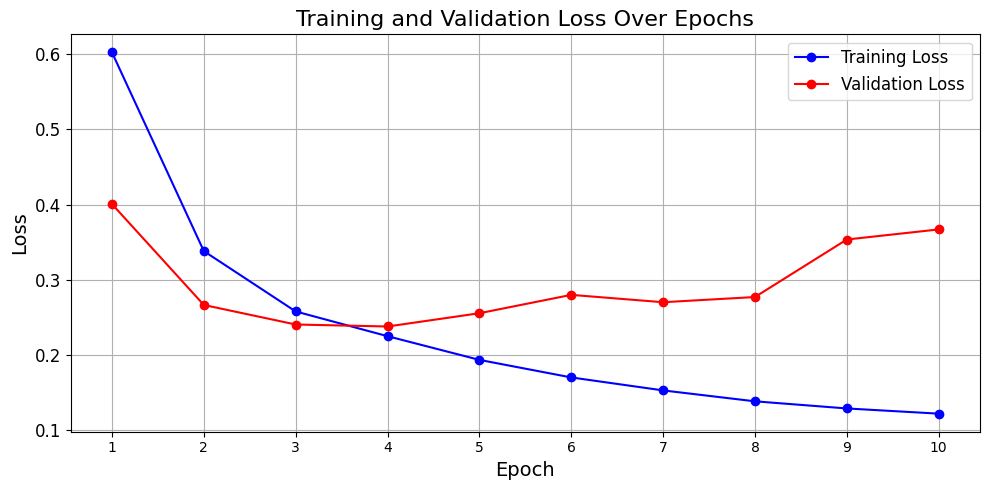

In [ ]:
# Training history
history_model6_df = pd.DataFrame(history_model6.history)

# Reset the index to start with 1
history_model6_df.index = range(1, len(history_model6_df) + 1)

# Save DataFrame as CSV
file_path = '/content/drive/My Drive/DS266 Project/model6_local_attention_optimized.csv'
history_model6_df.to_csv(file_path, index=False)

# Calling the improved plot function
plot_loss(history_model6_df)

* Model 3: Local Attention
Highest Training Accuracy: 93.89% (Epoch 9)
Highest Validation Accuracy: 88.43% (Epoch 3)
Final Validation Accuracy: 86.90%
Observations: The validation loss started increasing significantly after the third epoch, indicating potential overfitting as the model learns the training data too well but performs worse on unseen validation data.
* Model 3: Local Attention Optimized
Highest Training Accuracy: 93.73% (Epoch 10)
Highest Validation Accuracy: 88.46% (Epoch 3)
Final Validation Accuracy: 87.54%
Observations: This model shows a more gradual increase in validation loss compared to Model 1, although it too shows signs of overfitting towards the later epochs as the validation loss starts to increase after reaching a minimum.
*Comparison
Stability: Model 2 shows a more stable learning curve with a less drastic increase in validation loss, suggesting better generalization compared to Model 1.
Performance: Both models achieve similar highest validation accuracies (around 88.4%), but Model 2 maintains a higher accuracy by the final epoch.
Overfitting: Both models exhibit signs of overfitting, but it's more pronounced in Model 1 with a very high spike in validation loss, whereas Model 2 increases more gradually.
*Conclusion
Model 2 performs slightly better in terms of maintaining a more stable validation loss and a slightly higher final validation accuracy. It suggests that Model 2 might be better at generalizing to new, unseen data compared to Model 1. However, both models would benefit from strategies to reduce overfitting, such as introducing regularization techniques, adjusting the dropout rate, or employing early stopping during training.

In [ ]:
# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Ensure d_model is a float
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is a float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32 to ensure compatibility
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        # Ensure division by sqrt of d_model
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Return python float
            "warmup_steps": self.warmup_steps.numpy()  # Return python float
        }

# Directory where the model is saved
model_dir = '/content/drive/My Drive/DS266 Project/local_attention'

# Load the model back from the SavedModel format, including the custom schedule
loaded_model = tf.keras.models.load_model(
    model_dir,
    custom_objects={'CustomSchedule': CustomSchedule}
)

In [ ]:
embeddings_after_training = loaded_model.encoder.pos_embedding.embedding.get_weights()[0]
embeddings_after_training.shape

(22651, 100)

In [ ]:
# Create the model instance
model6 = TransformerClassifier(
    num_layers=1,
    d_model=64,
    num_heads=2,
    dff=512,
    input_vocab_size=max(tokenizer.word_index.values()) + 1,
    dropout_rate=0.3)